In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import datacube
from datacube.utils import geometry
import numpy as np
import geopandas as gpd

import sys
sys.path.append('../Scripts')
from deafrica_spatialtools import xr_rasterize

import warnings
warnings.filterwarnings("ignore")


In [2]:
dc = datacube.Datacube()

In [3]:
import glob, os

areas = glob.glob('../../shapes/AEZs_ExcludeLargeWB/*.shp')
areas

['../../shapes/AEZs_ExcludeLargeWB/AEZs_ExcludeLargeWB_update_Southern.shp',
 '../../shapes/AEZs_ExcludeLargeWB/AEZs_ExcludeLargeWB_update_Northern.shp',
 '../../shapes/AEZs_ExcludeLargeWB/AEZs_ExcludeLargeWB_update_Western.shp',
 '../../shapes/AEZs_ExcludeLargeWB/AEZs_ExcludeLargeWB_update_Eastern.shp',
 '../../shapes/AEZs_ExcludeLargeWB/AEZs_ExcludeLargeWB_update_Sahel.shp',
 '../../shapes/AEZs_ExcludeLargeWB/AEZs_ExcludeLargeWB_update_IndianOcean.shp',
 '../../shapes/AEZs_ExcludeLargeWB/AEZs_ExcludeLargeWB_update_Central.shp']

Sahel
Rasterizing to match xarray.DataArray dimensions (118904, 221753) and projection system/CRS (e.g. PROJCS["WGS 84 / NSIDC EASE-Grid 2.0 Global",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Cylindrical_Equal_Area"],PARAMETER["standard_parallel_1",30],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","6933"]])
0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0
percentile for ephemeral and permanent water [0.99693804 0.99916732]
IndianOcean
Rasterizing to match xarray.DataArray dimensions (57389, 24975) and projection system/CRS (e.g. PROJCS["WGS 84 / NSIDC EASE-Grid 2.0 Global",GEOGCS["WGS 84",DATUM["WG

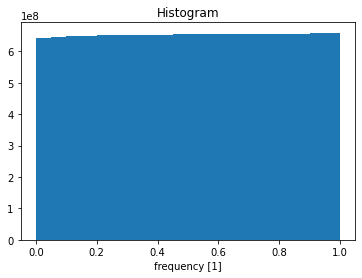

In [4]:
%%time

for aez_region in areas:
    name = aez_region.split('/')[-1].split('.')[0].split('_')[-1]
    if os.path.exists(f'wofs_summary_aez/wofs_{name}.csv'): continue
    print(name)
    aez=gpd.read_file(aez_region)
    geom = geometry.Geometry(aez.iloc[0].geometry.__geo_interface__,
                             geometry.CRS(f'EPSG:{aez.crs.to_epsg()}'))
    # load wofs
    wofs = dc.load(product='ga_ls8c_wofs_2_summary', measurements=['frequency'], dask_chunks={'x':2000,'y':2000}, geopolygon=geom).squeeze()
    # clip
    mask = xr_rasterize(gdf=aez, da=wofs.frequency)
    clipped_wofs = wofs.where(mask)
    
    if not name in ['Sahel', 'Northern', 'Southern', 'Central']:

        histy, histx, temp = clipped_wofs.frequency.plot.hist(bins=np.arange(0.0,1.05,0.05), cumulative=True, density=False)
        cum = histy/histy[-1]
        np.savetxt(f'wofs_summary_aez/wofs_{name}.csv', np.vstack((histx[1:], cum, histy)).transpose(),fmt='%.2f, %f, %d', delimiter=',')

        x, y = histx[1:], histy

    else:
        # for bigger regions
        bins = np.arange(0.1,1.05,0.1)
        cum_count = []
        for upper in bins:
            print(upper)
            cum_count.append((clipped_wofs.frequency<=upper).sum().values)
        cum_count = np.array(cum_count)
        cum = cum_count/cum_count[-1]
        np.savetxt(f'wofs_summary_aez/wofs_{name}.csv', np.vstack((bins, cum, cum_count)).transpose(),fmt='%.2f, %f, %d', delimiter=',')
        
        x, y = bins, cum
        
    ephem = 0.2
    perm = 0.9
    perc = np.interp([ephem, perm], x, y)
    print('percentile for ephemeral and permanent water', perc)
 
    #fig=plt.figure()
    #plt.plot(x, y)
    #plt.xlim((0,1))
    #plt.xticks(np.arange(0,1.05,0.1))
    #plt.xlabel('upper bound wofs frequency')
    #plt.ylabel('fraction of pixels')
    #plt.savefig(f'wofs_summary_aez/wofs_{name}.png')
